# Predictive Modeling 
One of the key uses of data recorded in the past is to attempt to make inferences about the future. 

In [1]:
import pandas as pd
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dur_utils import colours
from scipy import stats

path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
co2_data_ml = co2_data_ml[co2_data_ml['sdev']>0] 

In [2]:
# Training Set
mask = np.where(co2_data_ml['year'] < 2018)
train_co2_data = co2_data_ml.iloc[mask]
# Validation Set
val_years = [i for i in range(2018, 2020)]
mask = np.isin(co2_data_ml['year'], val_years)
val_co2_data = co2_data_ml.iloc[mask]
# Test Set
test_years = [i for i in range(2020, 2022)]
mask = np.isin(co2_data_ml['year'], test_years)
test_co2_data = co2_data_ml.iloc[mask]

In [3]:

def model(x, a_0, a_1, omega_0, omega_1, c, p_1,p_2,p_3):
    polynomial = x*p_1 + x**2*p_2 +x**3*p_3
    trig = a_0*np.cos((x + 1/2)*2*np.pi*omega_0) \
        + a_1*np.cos((x + 1/2)*2*np.pi*omega_1)
    return c + trig + polynomial

model_fit, model_error = scipy.optimize.curve_fit(model,
    co2_data_ml['decimal date'],
    co2_data_ml['average'],
    sigma = co2_data_ml['sdev'],
    p0=[5,5,1,2,0,0,0,0] # Inital Parameter Guess
    )
#chisq
model_ml = model(co2_data_ml['decimal date'], *model_fit)
model_residuals = model_ml - co2_data_ml['average']
chisq_model = np.sum((model_residuals
    / co2_data_ml['sdev'])**2
    )
nu_model = co2_data_ml['average'].shape[0] - len(model_fit)
p_model = stats.chi2.sf(chisq_model,nu_model)
chi_crit = stats.chi2.isf(.05,nu_model)


```{sidebar} Classes
Classes are the staple of Object oriented programming(OOP). They are something you can call which has methods, these are functions of the object and they have attributes which are stored inside them. A good example of a class is a list. It has multiple functions like `__len__()` which returns the instance of the classes length. Where the instance is the specific class a list of `[1, 2, 3]` for example. The atributes of the list are its values. When implementing a class it is considered good practice to only have users interact with methods. 
```

In [4]:
class FittedModel:
    def __init__(self, fn, x, y, sigma = None, p0 = None, name = None):
        self.fn  = fn
        self.x = x
        self.y = y
        self.sigma = sigma
        self.p0 = p0
        self.name = name
        self.fit_coefs , self.fit_errs = self.get_fit()
    
    def get_fit(self) :
        '''Applies scipy.optimize.curve_fit() to the passed args.

        returns fit_coefs array, correlation_array  
        '''
        model_fit, model_error = scipy.optimize.curve_fit(self.fn,
            self.x,
            self.y,
            sigma=self.sigma,
            p0=self.p0
            )
        return model_fit, model_error
    
    def fit_data(self):
        '''Returns the fitted function evaluated on x'''
        return self.fn(self.x, *self.fit_coefs)
    
    def get_chi2(self):
        '''Returns the chi^2 value of the model'''
        fit = self.fit_data()
        residuals = fit - self.y
        if self.sigma is not None:
            chi2 = np.sum((residuals / self.sigma)**2)
        else:
            print('No Uncertanity, Using Expectation')
            print('Expectation of the values is: E(residuals)') 
            chi2 = np.sum((residuals / np.mean(residuals))**2)
        return chi2

    def get_nu(self):
        '''Returns the degrees of freedom of the model'''
        return len(self.x) - len(self.fit_coefs)
    
    def get_sf(self):
        '''Returns P(chi^2 > chi^2_min)'''
        chi_min = self.get_chi2()
        nu = self.get_nu()
        return scipy.stats.chi2.sf(chi_min, nu)
    def print_errors(self):
        diagonal = np.diagonal(self.fit_errs)
        for i, (value, error) in enumerate(zip(self.fit_coefs,diagonal)):
            print(f'Parameter {i + 1} = {value:.2} +_ {error:.1}')
        
        

In [5]:
train  = FittedModel(model,
    train_co2_data['decimal date'],
    train_co2_data['average'],
    sigma=train_co2_data['sdev'],
    p0=[5,5,1,2,0,0,0,0],
    name = 'Training Model'
    )
test  = FittedModel(model,
    test_co2_data['decimal date'],
    test_co2_data['average'],
    sigma=test_co2_data['sdev'],
    p0=[5,5,1,2,0,0,0,0],
    name = 'Test Model'
    )
val  = FittedModel(model,
    val_co2_data['decimal date'],
    val_co2_data['average'],
    sigma=val_co2_data['sdev'],
    p0=[5,5,1,2,0,0,0,0],
    name = 'Validation Model'
    )

In [6]:
for model_ in [train, val, test]:
    print(model_.name)
    print(f'chi^2 = {model_.get_chi2()}')
    print(f'P(chi^2 > chi^2_min) = {model_.get_sf()}')
    print('/n')

Training Model
chi^2 = 1131.758263016564
P(chi^2 > chi^2_min) = 1.845316008940775e-48
/n
Validation Model
chi^2 = 5.081359824572485
P(chi^2 > chi^2_min) = 0.9953338786491481
/n
Test Model
chi^2 = 4.323603239880887
P(chi^2 > chi^2_min) = 0.9982233493809096
/n


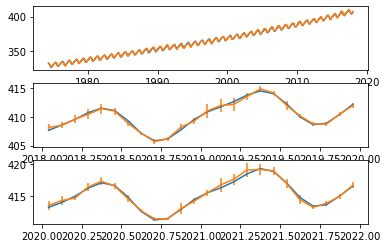

In [7]:
fig, ax  = plt.subplots(3,1)
for i, model_ in enumerate([train, val, test]):
    ax[i].plot(model_.x, model_.fit_data())
    ax[i].errorbar(model_.x, model_.y, model_.sigma)